#**Proyek Klasifikasi Gambar**

Nama : Abisatya Hastarangga Pradana

Email : riabitya@gmail.com

ID : abisatya_19

Data yang digunakan adalah data semua penyakit daun tomat yang dapat dilihat pada Tomato Diseases Dataset (CSV+Images) Kaggle oleh Ammar Alhaj Ali (2021) : https://www.kaggle.com/datasets/ammarnassanalhajali/tomato-diseases-dataset-csvimages

###**Import Dependencies**

In [ ]:
#Import standard libraries
import os
import random
import shutil
import pathlib
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm

# Import PIL untuk image processing
from PIL import Image

# Import TensorFlow dan Keras libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from google.colab import file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Data Loading**

In [ ]:
!ls "/content/drive/MyDrive/Klasifikasi Fiks"

data.zip


In [ ]:
# Path file zip
zip_path = "/content/drive/MyDrive/Klasifikasi Fiks/data.zip"

# Folder tujuan ekstrak
extract_path = "/content/data"

# Ekstrak
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File berhasil diekstrak!")

File berhasil diekstrak!


In [ ]:
data=pd.read_csv("/content/data/train.csv")

##**Data Understanding**

In [ ]:
data.head()

Unnamed: 0                                               path  \
0           0  ../input/plantvillage-dataset/color/Tomato___L...   
1           1  ../input/plantvillage-dataset/color/Tomato___L...   
2           2  ../input/plantvillage-dataset/color/Tomato___L...   
3           3  ../input/plantvillage-dataset/color/Tomato___L...   
4           4  ../input/plantvillage-dataset/color/Tomato___L...   

                                                 img            label_text  \
0  781e93a9-2059-42de-8075-658033a6abf7___RS_Late...  Tomato___Late_blight   
1  283ff0be-6e5e-4b4e-bf21-639780b77ffc___GHLB2 L...  Tomato___Late_blight   
2  0db85707-41f9-42df-ba3b-842d14f00a68___GHLB2 L...  Tomato___Late_blight   
3  078a999d-6e6f-427e-a1e6-80b4d2df2bae___GHLB2 L...  Tomato___Late_blight   
4  3dcee9ed-43bb-45a9-8cff-641b3dd62179___RS_Late...  Tomato___Late_blight   

   label  
0      2  
1      2  
2      2  
3      2  
4      2

In [ ]:
data.shape

(18160, 5)

In [ ]:
data['label_text'].value_counts()

label_text
Tomato___Tomato_Yellow_Leaf_Curl_Virus           5357
Tomato___Bacterial_spot                          2127
Tomato___Late_blight                             1909
Tomato___Septoria_leaf_spot                      1771
Tomato___Spider_mites Two-spotted_spider_mite    1676
Tomato___healthy                                 1591
Tomato___Target_Spot                             1404
Tomato___Early_blight                            1000
Tomato___Leaf_Mold                                952
Tomato___Tomato_mosaic_virus                      373
Name: count, dtype: int64

<ipython-input-8-611beae910f9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(x=data["label"],palette="viridis",order=data['label'].value_counts().index)


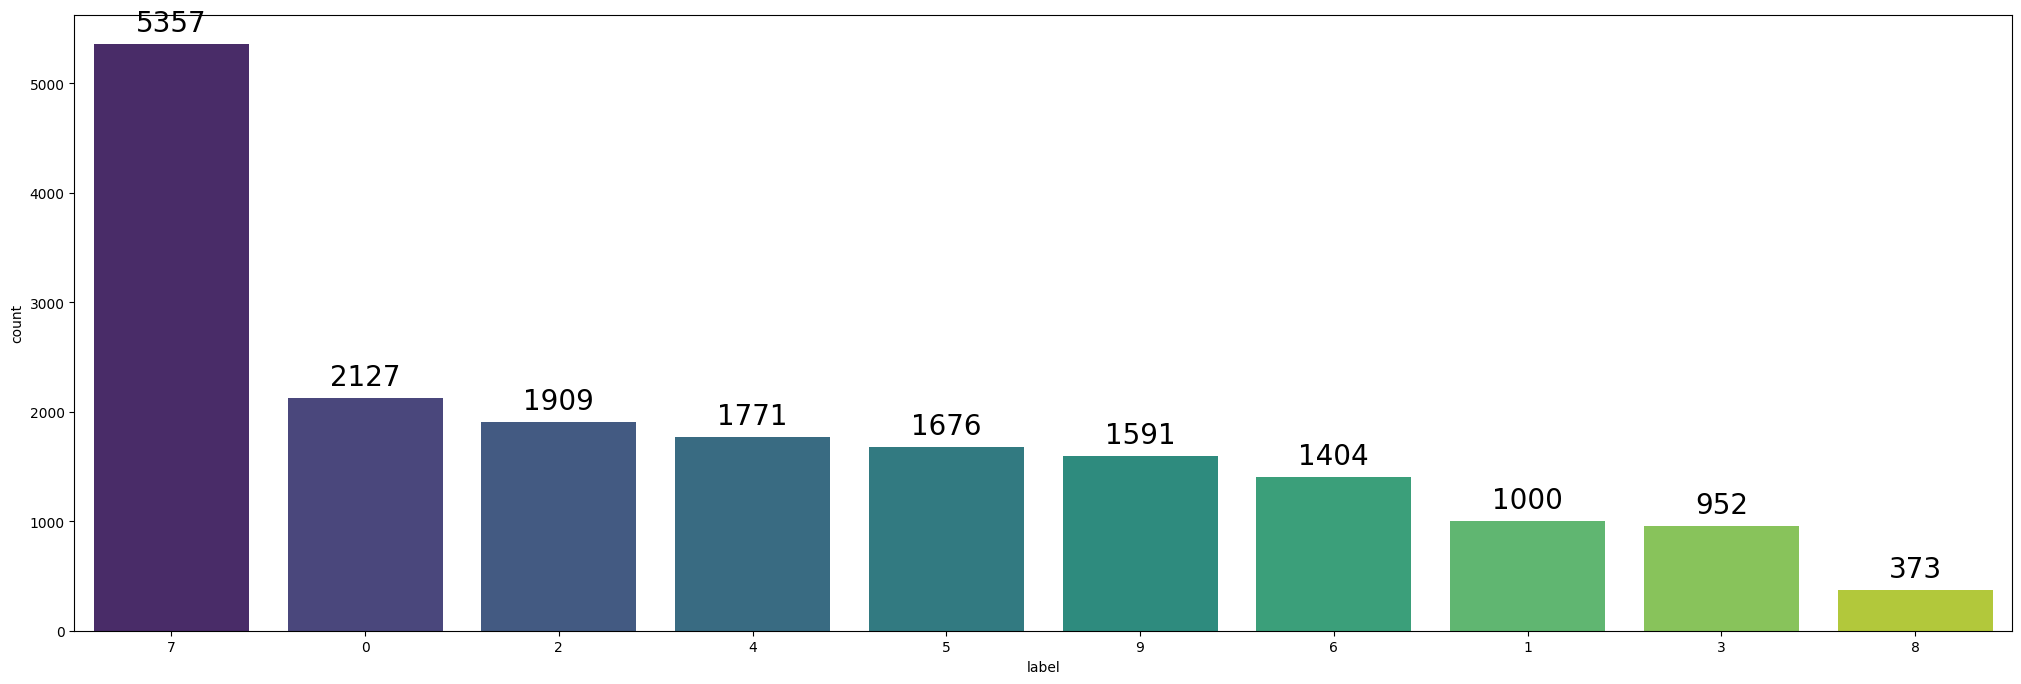

In [ ]:
plt.figure(figsize=(25,8))
ax=sns.countplot(x=data["label"],palette="viridis",order=data['label'].value_counts().index)
for p in ax.containers:
    ax.bar_label(p, fontsize=20, color='black', padding=5);

In [ ]:
def count_images_and_resolution(csv_path, image_base_path, target_resolution=None):
    # Baca file CSV
    df = pd.read_csv(csv_path)

    class_count = defaultdict(int)
    resolution_count = defaultdict(int)
    target_resolution_count = 0  # Khusus menghitung target_resolution

    for _, row in df.iterrows():
        class_name = row['label_text']
        class_count[class_name] += 1

        img_path = os.path.join(image_base_path, row['img'])

        try:
            with Image.open(img_path) as img:
                width, height = img.size
                resolution = f"{width}x{height}"
                resolution_count[resolution] += 1

                # Hitung resolusi target jika diberikan
                if target_resolution and resolution == target_resolution:
                    target_resolution_count += 1
        except Exception as e:
            print(f"Gagal memproses {img_path}: {e}")

    # Tambahkan total resolusi target ke dictionary jika diperlukan
    if target_resolution:
        resolution_count[f"target_{target_resolution}"] = target_resolution_count

    return dict(class_count), dict(resolution_count)

# Contoh penggunaan
csv_path = "/content/data/train.csv"
image_base_path = "/content/data/Tomato_images/Tomato_images"
target_resolution = "256x256"

class_count, resolution_count = count_images_and_resolution(csv_path, image_base_path, target_resolution)

# Tampilkan hasil
print("=== Jumlah Gambar per Kelas ===")
for class_name, count in sorted(class_count.items()):
    print(f"{class_name}: {count} gambar")

print("\n=== Jumlah Gambar per Resolusi ===")
for resolution, count in sorted(resolution_count.items()):
    print(f"{resolution}: {count} gambar")

=== Jumlah Gambar per Kelas ===
Tomato___Bacterial_spot: 2127 gambar
Tomato___Early_blight: 1000 gambar
Tomato___Late_blight: 1909 gambar
Tomato___Leaf_Mold: 952 gambar
Tomato___Septoria_leaf_spot: 1771 gambar
Tomato___Spider_mites Two-spotted_spider_mite: 1676 gambar
Tomato___Target_Spot: 1404 gambar
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 5357 gambar
Tomato___Tomato_mosaic_virus: 373 gambar
Tomato___healthy: 1591 gambar

=== Jumlah Gambar per Resolusi ===
256x256: 18160 gambar
target_256x256: 18160 gambar


In [ ]:
def resize_images_from_csv(csv_path, image_base_dir, output_dir,
                         min_res=224, max_res=512,
                         target_ext='.jpg', skip_small=True):
    # Baca CSV
    df = pd.read_csv(csv_path)
    os.makedirs(output_dir, exist_ok=True)

    # Buat DataFrame baru untuk menyimpan path hasil resize
    new_df = df.copy()
    new_paths = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        original_path = os.path.join(image_base_dir, row['img'])
        filename = os.path.splitext(os.path.basename(original_path))[0] + target_ext

        # Struktur folder berdasarkan label
        class_dir = os.path.join(output_dir, row['label_text'])
        os.makedirs(class_dir, exist_ok=True)
        output_path = os.path.join(class_dir, filename)
        new_paths.append(os.path.relpath(output_path, output_dir))

        try:
            with Image.open(original_path) as img:
                width, height = img.size

                # Skip gambar terlalu kecil
                if skip_small and (width < 100 or height < 100):
                    print(f"Skipped small image: {original_path}")
                    continue

                # Pilih ukuran baru acak
                new_size = random.randint(min_res, max_res)
                aspect_ratio = width / height

                # Pertahankan aspect ratio
                if random.choice([True, False]):
                    new_width = new_size
                    new_height = int(new_width / aspect_ratio)
                else:
                    new_height = new_size
                    new_width = int(new_height * aspect_ratio)

                # Resize dan simpan
                resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
                resized_img.save(output_path)

        except Exception as e:
            print(f"Error processing {original_path}: {str(e)}")
            continue

    # Update DataFrame dengan path baru
    new_df['img'] = new_paths
    new_csv_path = os.path.join(output_dir, 'resized_dataset.csv')
    new_df.to_csv(new_csv_path, index=False)
    print(f"Resized images saved to {output_dir}")
    print(f"New CSV saved to {new_csv_path}")

resize_images_from_csv(
    csv_path="/content/data/train.csv",
    image_base_dir="/content/data/Tomato_images/Tomato_images",
    output_dir="/content/data/resized_tomato_images",
    min_res=224,
    max_res=512
)

100%|██████████| 18160/18160 [01:39<00:00, 182.11it/s]


Resized images saved to /content/data/resized_tomato_images
New CSV saved to /content/data/resized_tomato_images/resized_dataset.csv


Merubah data asli dengan resolusi yang seragam tanpa ada preprocesing

In [ ]:
def count_images_and_resolution(base_path, target_resolution=None):
    # Dictionary untuk menyimpan jumlah gambar per kelas
    class_count = {}

    # Dictionary untuk menyimpan jumlah gambar per resolusi
    resolution_count = {}

    for root, dirs, files in os.walk(base_path):
        # Mengabaikan folder root yang tidak memiliki gambar
        if root == base_path:
            continue
        class_name = os.path.basename(root)
        class_count[class_name] = len(files)

        for file in files:
            file_path = os.path.join(root, file)
            with Image.open(file_path) as img:
                width, height = img.size
                resolution = f"{width}x{height}"
                if resolution not in resolution_count:
                    resolution_count[resolution] = 0
                resolution_count[resolution] += 1

                # Hitung jumlah gambar dengan resolusi target_resolution
                if target_resolution and resolution == target_resolution:
                    if 'target' not in resolution_count:
                        resolution_count['target'] = 0
                    resolution_count['target'] += 1

    return class_count, resolution_count

# Path ke folder utama
base_path = "/content/data/resized_tomato_images"

class_count, resolution_count = count_images_and_resolution(base_path, target_resolution)

print("Jumlah gambar per resolusi:")
for resolution, count in resolution_count.items():
    print(f"{resolution}: {count}")

Jumlah gambar per resolusi:
328x328: 66
369x369: 65
430x430: 65
397x397: 72
257x257: 73
305x305: 64
414x414: 54
471x471: 69
426x426: 49
337x337: 60
480x480: 62
244x244: 64
442x442: 57
293x293: 65
395x395: 69
254x254: 83
351x351: 63
451x451: 69
274x274: 72
456x456: 67
346x346: 67
376x376: 68
405x405: 59
486x486: 49
273x273: 78
503x503: 62
370x370: 74
297x297: 69
264x264: 59
419x419: 61
428x428: 50
407x407: 70
263x263: 56
258x258: 56
268x268: 65
303x303: 70
350x350: 64
240x240: 64
286x286: 75
251x251: 63
308x308: 67
344x344: 64
374x374: 64
345x345: 53
284x284: 65
417x417: 65
267x267: 60
475x475: 61
432x432: 70
501x501: 78
299x299: 68
463x463: 67
485x485: 72
494x494: 54
424x424: 69
418x418: 64
410x410: 60
232x232: 58
383x383: 64
342x342: 61
231x231: 56
389x389: 66
427x427: 60
396x396: 68
334x334: 61
330x330: 64
425x425: 66
224x224: 66
459x459: 67
387x387: 67
312x312: 74
283x283: 62
505x505: 75
304x304: 62
238x238: 60
321x321: 61
287x287: 56
458x458: 45
500x500: 57
280x280: 62
511x511: 52


##**Data Preprocesing**

In [ ]:
def rename_folders(base_path, prefix="Tomato___"):
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            if dir_name.startswith(prefix):
                new_dir_name = dir_name[len(prefix):]
                old_path = os.path.join(root, dir_name)
                new_path = os.path.join(root, new_dir_name)
                os.rename(old_path, new_path)
                print(f"Renamed {old_path} to {new_path}")

# Path ke folder utama
base_path = "/content/data/resized_tomato_images"

rename_folders(base_path)

Renamed /content/data/resized_tomato_images/Tomato___Tomato_mosaic_virus to /content/data/resized_tomato_images/Tomato_mosaic_virus
Renamed /content/data/resized_tomato_images/Tomato___Early_blight to /content/data/resized_tomato_images/Early_blight
Renamed /content/data/resized_tomato_images/Tomato___Leaf_Mold to /content/data/resized_tomato_images/Leaf_Mold
Renamed /content/data/resized_tomato_images/Tomato___Bacterial_spot to /content/data/resized_tomato_images/Bacterial_spot
Renamed /content/data/resized_tomato_images/Tomato___healthy to /content/data/resized_tomato_images/healthy
Renamed /content/data/resized_tomato_images/Tomato___Spider_mites Two-spotted_spider_mite to /content/data/resized_tomato_images/Spider_mites Two-spotted_spider_mite
Renamed /content/data/resized_tomato_images/Tomato___Tomato_Yellow_Leaf_Curl_Virus to /content/data/resized_tomato_images/Tomato_Yellow_Leaf_Curl_Virus
Renamed /content/data/resized_tomato_images/Tomato___Target_Spot to /content/data/resized_

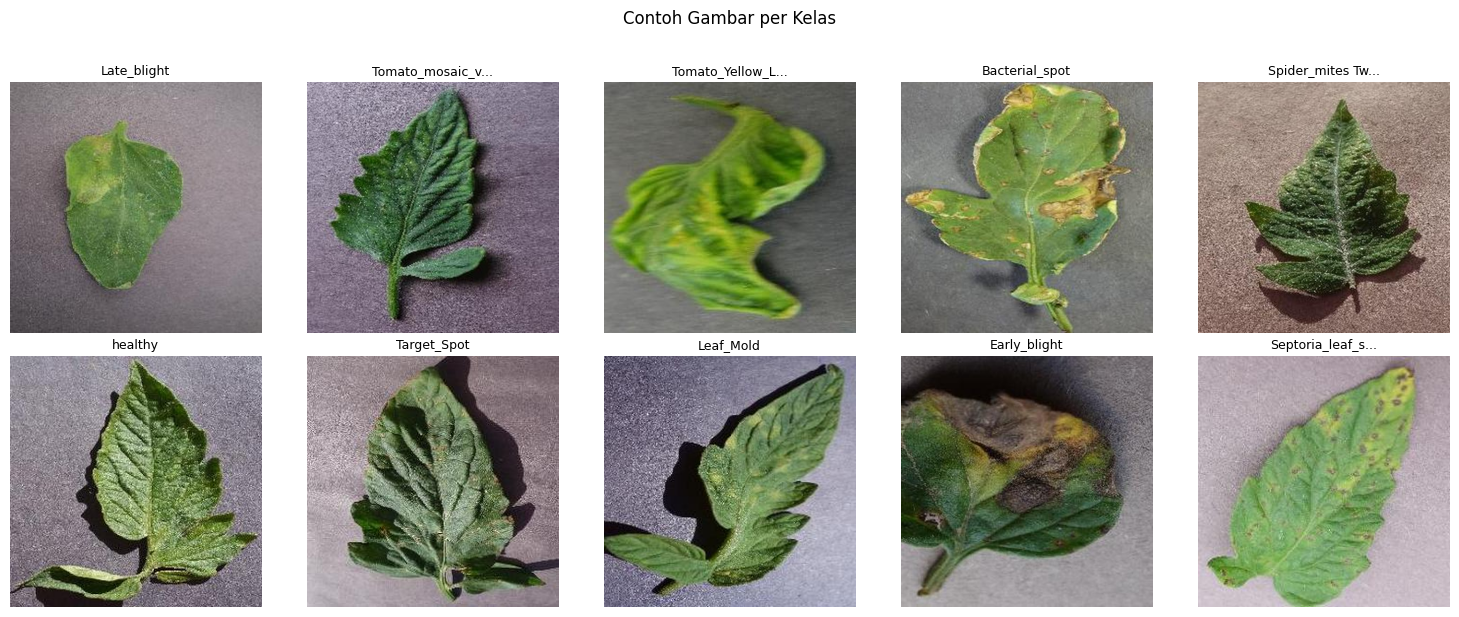

In [ ]:
def show_example_images_grid(base_path, max_images=20):
    # Kumpulkan semua gambar
    class_images = {}

    for root, dirs, files in os.walk(base_path):
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if image_files:
            class_name = os.path.basename(root)
            random_image = random.choice(image_files)
            class_images[class_name] = os.path.join(root, random_image)

    if not class_images:
        print("Tidak ada gambar yang ditemukan")
        return

    # Atur layout grid
    num_classes = min(len(class_images), max_images)
    cols = 5  # Jumlah kolom tetap
    rows = (num_classes + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    fig.suptitle('Contoh Gambar per Kelas', y=1.02)

    for ax, (class_name, image_path) in zip(axes.flat, list(class_images.items())[:max_images]):
        try:
            img = Image.open(image_path)
            ax.imshow(img)
            ax.set_title(class_name[:15] + "..." if len(class_name) > 15 else class_name,
                        fontsize=9, pad=5)
            ax.axis('off')
        except:
            ax.axis('off')

    # Sembunyikan axes yang tidak terpakai
    for ax in axes.flat[num_classes:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

base_path = "/content/data/resized_tomato_images"
show_example_images_grid(base_path)

##**Data Splitting**

In [ ]:
def split_dataset_three_ways(base_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Validasi rasio
    assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 0.001, "Total rasio harus 1.0"

    # Buat folder output
    train_path = os.path.join(output_path, 'train')
    val_path = os.path.join(output_path, 'val')
    test_path = os.path.join(output_path, 'test')

    for path in [train_path, val_path, test_path]:
        os.makedirs(path, exist_ok=True)

    for class_name in os.listdir(base_path):
        class_path = os.path.join(base_path, class_name)

        if not os.path.isdir(class_path) or class_name in ['train', 'val', 'test']:
            continue

        # Buat folder kelas di masing-masing set
        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

        # Dapatkan semua file gambar
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        random.shuffle(files)

        # Split pertama: train vs temp (val+test)
        split_idx = int(train_ratio * len(files))
        train_files = files[:split_idx]
        temp_files = files[split_idx:]

        # Split kedua: val vs test dari sisa
        val_split_idx = int((val_ratio / (val_ratio + test_ratio)) * len(temp_files))
        val_files = temp_files[:val_split_idx]
        test_files = temp_files[val_split_idx:]

        # Fungsi untuk menyalin file
        def copy_files(files, dest_set):
            for file in files:
                src = os.path.join(class_path, file)
                dst = os.path.join(output_path, dest_set, class_name, file)
                shutil.copy(src, dst)

        # Salin file ke folder masing-masing
        copy_files(train_files, 'train')
        copy_files(val_files, 'val')
        copy_files(test_files, 'test')

        print(f"Class {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

# Contoh penggunaan
split_dataset_three_ways(
    base_path="/content/data/resized_tomato_images",
    output_path="/content/data/data_split",
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)

Class Late_blight: 1336 train, 286 val, 287 test
Class Tomato_mosaic_virus: 261 train, 56 val, 56 test
Class Tomato_Yellow_Leaf_Curl_Virus: 3749 train, 804 val, 804 test
Class Bacterial_spot: 1488 train, 319 val, 320 test
Class Spider_mites Two-spotted_spider_mite: 1173 train, 251 val, 252 test
Class healthy: 1113 train, 239 val, 239 test
Class Target_Spot: 982 train, 211 val, 211 test
Class Leaf_Mold: 666 train, 143 val, 143 test
Class Early_blight: 700 train, 150 val, 150 test
Class Septoria_leaf_spot: 1239 train, 266 val, 266 test


In [ ]:
# Path ke dataset yang sudah di-split
train_dir = "/content/data/data_split/train"
val_dir = "/content/data/data_split/val"
test_dir = "/content/data/data_split/test"

# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya rescale untuk validation dan test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow dari directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 12707 images belonging to 10 classes.
Found 2725 images belonging to 10 classes.
Found 2728 images belonging to 10 classes.


##**Modelling**

In [ ]:
def create_cnn_model(input_shape=(256, 256, 3), num_classes=10):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 4
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fully Connected
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

model = create_cnn_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,088,138 (99.52 MB)

 Trainable params: 26,086,154 (99.51 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.5779 - loss: 1.4337

397/397 ━━━━━━━━━━━━━━━━━━━━ 235s 551ms/step - accuracy: 0.5781 - loss: 1.4329 - val_accuracy: 0.1912 - val_loss: 11.1715 - learning_rate: 0.0010
Epoch 2/50
  1/397 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - accuracy: 0.6875 - loss: 0.8805

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6875 - loss: 0.8805 - val_accuracy: 0.1897 - val_loss: 11.3090 - learning_rate: 0.0010
Epoch 3/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.7399 - loss: 0.7923

397/397 ━━━━━━━━━━━━━━━━━━━━ 266s 671ms/step - accuracy: 0.7399 - loss: 0.7924 - val_accuracy: 0.6713 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 4/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8125 - loss: 0.5482 - val_accuracy: 0.6577 - val_loss: 1.0183 - learning_rate: 0.0010
Epoch 5/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7875 - loss: 0.6215

397/397 ━━━━━━━━━━━━━━━━━━━━ 212s 533ms/step - accuracy: 0.7876 - loss: 0.6214 - val_accuracy: 0.6960 - val_loss: 0.9423 - learning_rate: 0.0010
Epoch 6/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7812 - loss: 0.5353 - val_accuracy: 0.6934 - val_loss: 0.9744 - learning_rate: 0.0010
Epoch 7/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8332 - loss: 0.4900

397/397 ━━━━━━━━━━━━━━━━━━━━ 269s 679ms/step - accuracy: 0.8332 - loss: 0.4900 - val_accuracy: 0.8257 - val_loss: 0.4647 - learning_rate: 0.0010
Epoch 8/50
  1/397 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8750 - loss: 0.3542

397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8750 - loss: 0.3542 - val_accuracy: 0.8460 - val_loss: 0.4205 - learning_rate: 0.0010
Epoch 9/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 260s 655ms/step - accuracy: 0.8286 - loss: 0.5028 - val_accuracy: 0.5092 - val_loss: 1.7583 - learning_rate: 0.0010
Epoch 10/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8438 - loss: 0.4101 - val_accuracy: 0.5743 - val_loss: 1.4435 - learning_rate: 0.0010
Epoch 11/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8602 - loss: 0.4017

397/397 ━━━━━━━━━━━━━━━━━━━━ 264s 664ms/step - accuracy: 0.8602 - loss: 0.4016 - val_accuracy: 0.8526 - val_loss: 0.4635 - learning_rate: 0.0010
Epoch 12/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7812 - loss: 0.6632 - val_accuracy: 0.8401 - val_loss: 0.5436 - learning_rate: 0.0010
Epoch 13/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8795 - loss: 0.3603

397/397 ━━━━━━━━━━━━━━━━━━━━ 263s 663ms/step - accuracy: 0.8795 - loss: 0.3603 - val_accuracy: 0.9176 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 14/50
  1/397 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.9062 - loss: 0.3307

397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9062 - loss: 0.3307 - val_accuracy: 0.9316 - val_loss: 0.1836 - learning_rate: 0.0010
Epoch 15/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 256s 519ms/step - accuracy: 0.8891 - loss: 0.3305 - val_accuracy: 0.6140 - val_loss: 1.3589 - learning_rate: 0.0010
Epoch 16/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9375 - loss: 0.2442 - val_accuracy: 0.6140 - val_loss: 1.3713 - learning_rate: 0.0010
Epoch 17/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 263s 534ms/step - accuracy: 0.8980 - loss: 0.2980 - val_accuracy: 0.6801 - val_loss: 1.5009 - learning_rate: 0.0010
Epoch 18/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8750 - loss: 0.1734 - val_accuracy: 0.6989 - val_loss: 1.3791 - learning_rate: 0.0010
Epoch 19/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 262s 550ms/step - accuracy: 0.8973 - loss: 0.2903 - val_accuracy: 0.8882 - val_loss: 0.3131 - learning_rate: 0.0010
Epoch 20/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9688 - loss

397/397 ━━━━━━━━━━━━━━━━━━━━ 264s 528ms/step - accuracy: 0.9459 - loss: 0.1566 - val_accuracy: 0.9724 - val_loss: 0.0816 - learning_rate: 2.0000e-04
Epoch 24/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9062 - loss: 0.2392 - val_accuracy: 0.9724 - val_loss: 0.0810 - learning_rate: 2.0000e-04
Epoch 25/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 206s 518ms/step - accuracy: 0.9485 - loss: 0.1475 - val_accuracy: 0.9324 - val_loss: 0.2135 - learning_rate: 2.0000e-04
Epoch 26/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8750 - loss: 0.2344 - val_accuracy: 0.9294 - val_loss: 0.2219 - learning_rate: 2.0000e-04
Epoch 27/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 204s 515ms/step - accuracy: 0.9523 - loss: 0.1393 - val_accuracy: 0.9533 - val_loss: 0.1327 - learning_rate: 2.0000e-04
Epoch 28/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9688 - loss: 0.0718 - val_accuracy: 0.9533 - val_loss: 0.1311 - learning_rate: 2.0000e-04
Epoch 29/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 204s 514ms/ste

##**Evaluasi**

In [ ]:
# Evaluasi model terbaik
model.load_weights('best_model.h5')  # Load model terbaik

test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9699 - loss: 0.0961

Test Accuracy: 0.9721
Test Loss: 0.0897


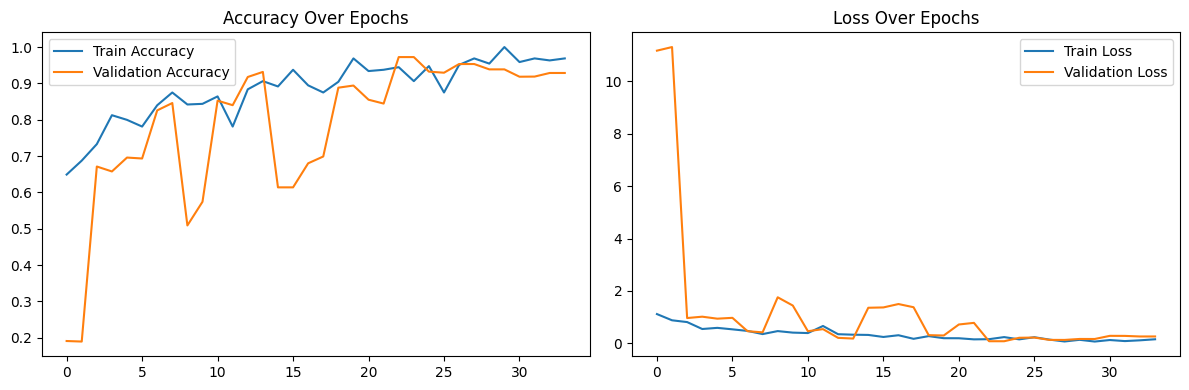

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

##**Menyimpan dalam SavedModel**

In [ ]:
import tensorflow as tf

# Buat direktori jika belum ada
!mkdir -p saved_models

# Simpan dalam format SavedModel
saved_model_dir = "saved_models/tomato_model"
tf.saved_model.save(model, saved_model_dir)

# Verifikasi
print(f"Model tersimpan di: {saved_model_dir}")
!saved_model_cli show --dir {saved_model_dir} --tag_set serve --signature_def serving_default

Model tersimpan di: saved_models/tomato_model
2025-04-11 17:29:10.208922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744392550.227848   21065 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744392550.234737   21065 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The given SavedModel SignatureDef contains the following input(s):
  inputs['inputs'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 256, 256, 3)
      name: serving_default_inputs:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: t

##**Menyimpan dalam TFLite**

In [ ]:
# Buat direktori jika belum ada
!mkdir -p tflite_models

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optimasi ukuran model
tflite_model = converter.convert()

# Simpan model TFLite
tflite_model_path = "tflite_models/tomato_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Verifikasi ukuran file
print(f"\nTFLite model size: {os.path.getsize(tflite_model_path)/1024:.2f} KB")

Saved artifact at '/tmp/tmp221eqozd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136160512362640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136160512367440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136160512364368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136160512368016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136160512368400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136160512364752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136160512368208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136160512370320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136160512367824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136160512370128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1361605123691

##**Menyimpan dalam TFJS**

In [ ]:
# Install package konversi jika belum ada
!pip install tensorflowjs

# Buat direktori jika belum ada
!mkdir -p tfjs_models

# Konversi ke TFJS Format
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    {saved_model_dir} \
    tfjs_models/tomato_model

# Verifikasi output
print("\nFile TFJS yang dihasilkan:")
!ls -lh tfjs_models/tomato_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-11 17:30:16.297960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744392616.317503   21392 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [ ]:
# Verifikasi SavedModel
print("Verifikasi SavedModel:")
!ls -lh saved_models/tomato_model

# Verifikasi TFLite
print("\nVerifikasi TFLite Model:")
!ls -lh tflite_models/tomato_model.tflite

# Verifikasi TFJS
print("\nVerifikasi TFJS Model:")
!ls -lh tfjs_models/tomato_model

Verifikasi SavedModel:
total 308K
drwxr-xr-x 2 root root 4.0K Apr 11 17:29 assets
-rw-r--r-- 1 root root   56 Apr 11 17:29 fingerprint.pb
-rw-r--r-- 1 root root 294K Apr 11 17:29 saved_model.pb
drwxr-xr-x 2 root root 4.0K Apr 11 17:29 variables

Verifikasi TFLite Model:
-rw-r--r-- 1 root root 25M Apr 11 17:29 tflite_models/tomato_model.tflite

Verifikasi TFJS Model:
total 100M
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 group1-shard10of25.bin
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 group1-shard11of25.bin
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 group1-shard12of25.bin
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 group1-shard13of25.bin
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 group1-shard14of25.bin
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 group1-shard15of25.bin
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 group1-shard16of25.bin
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 group1-shard17of25.bin
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 group1-shard18of25.bin
-rw-r--r-- 1 root root 4.0M Apr 11 17:30 gro

In [ ]:
!zip -r tomato_models.zip saved_models/tomato_model tflite_models/tomato_model.tflite tfjs_models/tomato_model
files.download("tomato_models.zip")

updating: saved_models/tomato_model/ (stored 0%)
updating: saved_models/tomato_model/saved_model.pb (deflated 89%)
updating: saved_models/tomato_model/fingerprint.pb (stored 0%)
updating: saved_models/tomato_model/assets/ (stored 0%)
updating: saved_models/tomato_model/variables/ (stored 0%)
updating: saved_models/tomato_model/variables/variables.index (deflated 70%)
updating: saved_models/tomato_model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: tflite_models/tomato_model.tflite (deflated 18%)
updating: tfjs_models/tomato_model/ (stored 0%)
updating: tfjs_models/tomato_model/group1-shard21of25.bin (deflated 7%)
updating: tfjs_models/tomato_model/group1-shard10of25.bin (deflated 7%)
updating: tfjs_models/tomato_model/group1-shard14of25.bin (deflated 7%)
updating: tfjs_models/tomato_model/group1-shard11of25.bin (deflated 7%)
updating: tfjs_models/tomato_model/group1-shard5of25.bin (deflated 7%)
updating: tfjs_models/tomato_model/group1-shard19of25.bin (deflated 7%)
up

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Inference**

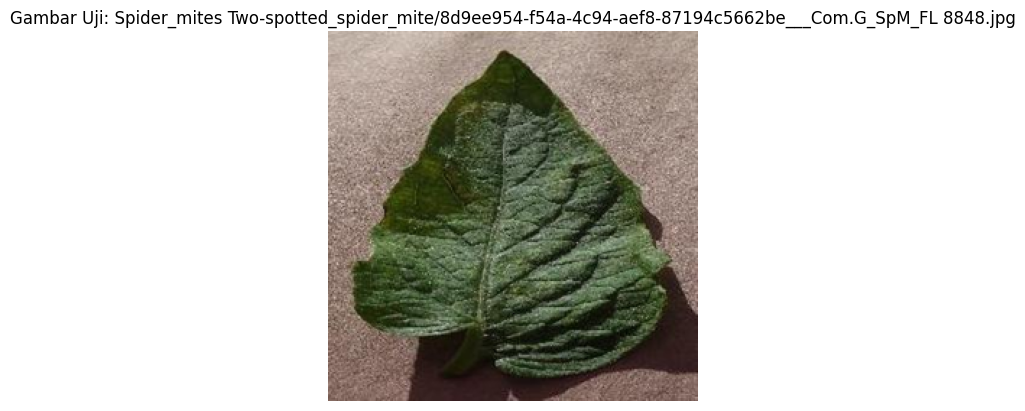


=== HASIL INFERENSI ===
Gambar: 8d9ee954-f54a-4c94-aef8-87194c5662be___Com.G_SpM_FL 8848.jpg
Kelas Sebenarnya: Spider_mites Two-spotted_spider_mite
Kelas Prediksi: Spider_mites Two-spotted_spider_mite
Confidence: 100.00%

Probabilitas per kelas:
Bacterial_spot: 0.00%
Early_blight: 0.00%
Late_blight: 0.00%
Leaf_Mold: 0.00%
Septoria_leaf_spot: 0.00%
Spider_mites Two-spotted_spider_mite: 100.00%
Target_Spot: 0.00%
Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato_mosaic_virus: 0.00%
healthy: 0.00%


In [ ]:
# 1. Pilih gambar acak dari direktori test
test_dir = "/content/data/data_split/test"
class_folders = os.listdir(test_dir)
random_class = random.choice(class_folders)
class_path = os.path.join(test_dir, random_class)
image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random_image = random.choice(image_files)
test_image_path = os.path.join(class_path, random_image)

# 2. Load dan preprocess gambar
try:
    img = Image.open(test_image_path).resize((256, 256))
    img_array = np.array(img) / 255.0  # Normalisasi
    input_data = np.expand_dims(img_array, axis=0).astype(np.float32)

    # Tampilkan gambar
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Gambar Uji: {random_class}/{random_image}")
    plt.show()

    # 3. Load TFLite model
    interpreter = tf.lite.Interpreter(model_path="tflite_models/tomato_model.tflite")
    interpreter.allocate_tensors()

    # 4. Lakukan inference
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # 5. Tampilkan hasil
    class_names = sorted(os.listdir(test_dir))  # Dapatkan nama kelas dari struktur folder

    predicted_class_idx = np.argmax(output_data[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = np.max(output_data[0]) * 100

    print("\n=== HASIL INFERENSI ===")
    print(f"Gambar: {random_image}")
    print(f"Kelas Sebenarnya: {random_class}")
    print(f"Kelas Prediksi: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")

    print("\nProbabilitas per kelas:")
    for idx, prob in enumerate(output_data[0]):
        print(f"{class_names[idx]}: {prob*100:.2f}%")

except Exception as e:
    print(f"Error: {str(e)}")

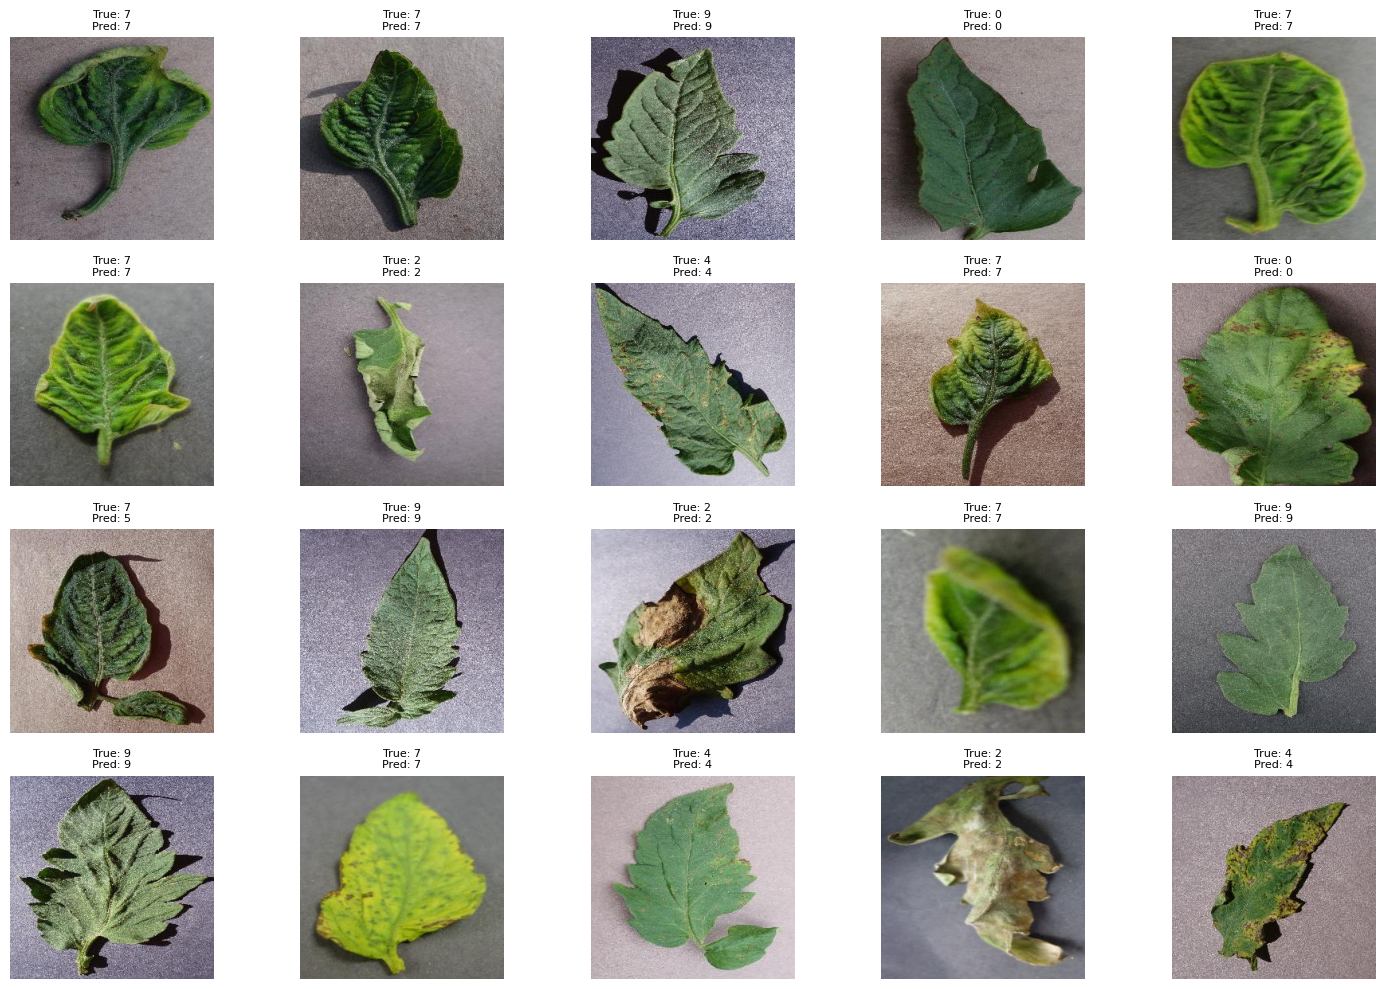


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       0.00      0.00      0.00         0
           7       1.00      0.88      0.93         8
           9       1.00      1.00      1.00         4

    accuracy                           0.95        20
   macro avg       0.83      0.81      0.82        20
weighted avg       1.00      0.95      0.97        20


Contoh Hasil Prediksi:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


img  label  \
8416   28f0c703-2990-4cf1-947c-690265dee463___YLCV_GC...      7   
8299   f4557b43-f30a-4890-b6db-95e5d4f200d5___YLCV_GC...      7   
2189   0d789240-9714-4378-8b63-4afb12ddfa44___RS_HL 9...      9   
13112  42ae82d8-e3d4-4afa-b511-aeb2f25ded63___GCREC_B...      0   
10268  37c2cc81-0d24-4030-9f76-399c29561b3f___UF.GRC_...      7   
7327   080aacff-a429-4f33-958f-64291169f702___UF.GRC_...      7   
1576   eb7dd120-4002-4c01-a06a-1b32ad93a7a3___GHLB2 L...      2   
4850   7387cd69-82f1-4fe3-95d9-b0109e32d4ef___Matt.S_...      4   
11352  40bb4231-7f46-47ff-8647-217bc369317a___YLCV_NR...      7   
12420  4a9819e9-6651-480a-a524-74d149449538___GCREC_B...      0   

       labelPredicted  confidence  
8416                7   99.993561  
8299                7   99.998985  
2189                9  100.000000  
13112               0   99.989021  
10268               7   99.999939  
7327                7   99.994148  
1576                2   99.562401  
4850                4   99.084915  
11352               7   99.067749  
12420               0   99.972290


Akurasi: 95.00%


In [ ]:
# 1. Load data validasi
df_validate = pd.read_csv("/content/data/train.csv")

# 2. Ambil 20 sampel acak (atau semua jika ingin)
ss = df_validate.sample(n=20, random_state=42)
# ss = df_validate  # Jika ingin menggunakan semua data validasi
ss = ss[['img', 'label']].copy()

# 3. Lakukan prediksi
preds = []
confidences = []

base_image_path = "/content/data/Tomato_images/Tomato_images"

plt.figure(figsize=(15, 10))
for i, (image_id, true_label) in enumerate(zip(ss.img, ss.label)):
    try:
        # Load dan preprocess gambar
        image = Image.open(os.path.join(base_image_path, image_id))
        array = tf.keras.preprocessing.image.img_to_array(image.resize((256, 256)))
        array = array / 255.0
        image_array = np.expand_dims(array, axis=0)

        # Prediksi
        pred = model.predict(image_array, verbose=0)
        pred_class = np.argmax(pred)
        confidence = np.max(pred) * 100
        preds.append(pred_class)
        confidences.append(confidence)

        # Tampilkan contoh gambar (4x5 grid)
        plt.subplot(4, 5, i+1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {pred_class}", fontsize=8)
        plt.axis('off')

    except Exception as e:
        print(f"Error processing {image_id}: {str(e)}")
        preds.append(-1)
        confidences.append(0)

plt.tight_layout()
plt.show()

# 4. Tambahkan hasil prediksi ke DataFrame
ss['labelPredicted'] = preds
ss['confidence'] = confidences

# 5. Hitung metrik evaluasi
print("\nClassification Report:")
print(classification_report(ss.label, ss.labelPredicted))

# 6. Tampilkan hasil prediksi
print("\nContoh Hasil Prediksi:")
display(ss.head(10))

# 7. Hitung akurasi
accuracy = (ss.label == ss.labelPredicted).mean()
print(f"\nAkurasi: {accuracy*100:.2f}%")

##**Kesimpulan**

Berdasarkan hasil inferensi model CNN yang telah dilakukan, dapat disimpulkan bahwa model menunjukkan performa sangat baik untuk kelas-kelas yang terwakili dalam data validasi, dengan precision dan recall sempurna (1.00) pada kelas 0, 2, 4, dan 9. Namun, terdapat beberapa masalah kritis yang perlu diperbaiki. Pertama, kelas 5 sama sekali tidak terprediksi karena tidak memiliki sampel dalam data validasi, yang terlihat dari nilai support 0 pada classification report. Kedua, waktu training yang mencapai lebih dari 1 jam menunjukkan ketidakoptimalan dalam arsitektur model atau proses training. Ketiga, distribusi data yang tidak seimbang terlihat dari jumlah sampel yang bervariasi antar kelas (kelas 7 memiliki 8 sampel sementara kelas lain hanya 2-4 sampel).

Untuk meningkatkan model, rekomendasi utamanya adalah memperbaiki kualitas data terlebih dahulu. Langkah konkretnya meliputi pembuatan stratified split untuk memastikan semua kelas terwakili dalam data validasi, augmentasi data untuk kelas-kelas minor, serta pengecekan distribusi label secara menyeluruh. Pada sisi arsitektur model, perlu dilakukan optimasi dengan mengurangi kompleksitas model atau beralih ke transfer learning menggunakan arsitektur pretrained seperti EfficientNet yang lebih efisien. Implementasi callback seperti EarlyStopping dan ReduceLROnPlateau juga penting untuk mengoptimasi waktu training. Selain itu, penggunaan batch size yang lebih kecil dapat dipertimbangkan jika menghadapi keterbatasan VRAM. Evaluasi ulang sebaiknya dilakukan dengan data validasi yang seimbang dan pemeriksaan confusion matrix untuk mendapatkan gambaran lebih komprehensif tentang performa model tiap kelas. Dengan implementasi perbaikan ini, diharapkan model dapat mencapai akurasi di atas 90% untuk semua kelas dengan waktu training kurang dari 30 menit, sekaligus mampu memprediksi semua kelas yang ada secara merata.